# NEW

In [144]:
from __future__ import print_function

import warnings
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, LeakyReLU
from keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import os

current_path = os.getcwd()
print(current_path)
warnings.filterwarnings("ignore")

/tf-knugs/werrayuth/VulScanner


In [145]:
df = pd.read_csv(current_path + '/Datasets/output_cleaned.csv')

In [146]:
df.head()

,code,label
0,const fs = require('fs');\nconst path = requir...,1
1,const fs = require('fs'); const path = require...,0
2,var fs = require('fs');\nvar filePath = fs.rea...,1
3,const express = require('express');\nconst app...,1
4,const childProcess = require('child_process');...,1


In [147]:
# Cleaning data 
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.columns = ['code', 'label']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   code    143 non-null    object
 1   label   143 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [239]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch

class BLSTM:
    def __init__(self, data, name="", batch_size=64, epochs=20, max_length=128):
        self.data = data
        self.name = name
        self.batch_size = batch_size
        self.epochs = epochs
        self.max_length = max_length

        # Load CodeBERT tokenizer and embedding model
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
        self.embedding_model = AutoModel.from_pretrained("microsoft/codebert-base")

        # Preprocess data
        self._preprocess_data()

        # Build and compile model
        self.model = self._build_model()

    def _preprocess_data(self):
        self.data['label'] = self.data['label'].astype(int)
        
        embeddings = []
        for code in self.data['code']:
            inputs = self.tokenizer(code, return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_length)
            with torch.no_grad():
                outputs = self.embedding_model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).detach().numpy()
            embeddings.append(embedding)

        self.X = np.array(embeddings).squeeze()
        self.y = self.data['label'].values

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=12
        )

    def _build_model(self):
        model = Sequential()
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(self.X_train.shape[1], 1)))
        model.add(Dropout(0.5))
        model.add(BatchNormalization())
        model.add(Bidirectional(LSTM(64)))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))
    
        model.compile(optimizer=Adam(learning_rate=0.02), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    
        return model

    def train(self):
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(self.name + "_best_model.weights.keras", save_best_only=True, monitor='val_loss')
        
        history = self.model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_test, self.y_test),
            batch_size=self.batch_size,
            epochs=self.epochs,
            callbacks=[early_stopping, model_checkpoint]
        )

        self._plot_learning_curve(history)

    def _plot_learning_curve(self, history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.ylim(0, 1)  # Set y-axis limit for accuracy
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.ylim(0, 2)  # Set y-axis limit for loss
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.show()

    def test(self):
        self.model.load_weights(self.name + "_best_model.weights.keras")
        results = self.model.evaluate(self.X_test, self.y_test)
        print("Test loss:", results[0])
        print("Test accuracy:", results[1])
        print("Test AUC:", results[2])

    def predict_code(self, file_path):
        with open(file_path, 'r') as f:
            code_lines = f.readlines()

        vulnerable_lines = []
        predictions = []

        for idx, line in enumerate(code_lines):
            line = line.strip()
            if not line:
                continue
            inputs = self.tokenizer([line], return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_length)
            with torch.no_grad():
                outputs = self.embedding_model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
            embeddings = np.expand_dims(embeddings, axis=1)

            prediction = self.model.predict(embeddings)
            predicted_class = 1 if prediction > 0.5 else 0

            predictions.append(predicted_class)
            if predicted_class == 1:
                vulnerable_lines.append(idx)

        result = "Vulnerable" if 1 in predictions else "Non-Vulnerable"
        vulnerable_code_lines = [f"{idx + 1}: {code_lines[i].strip()}" for i in vulnerable_lines]

        return result, vulnerable_code_lines


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 374ms/step - AUC: 0.4347 - accuracy: 0.4615 - loss: 1.2524 - val_AUC: 0.4412 - val_accuracy: 0.5862 - val_loss: 0.8350
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step - AUC: 0.5582 - accuracy: 0.5655 - loss: 0.8914 - val_AUC: 0.5564 - val_accuracy: 0.5517 - val_loss: 0.6862
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - AUC: 0.5018 - accuracy: 0.5398 - loss: 1.0064 - val_AUC: 0.4314 - val_accuracy: 0.4138 - val_loss: 0.8546
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - AUC: 0.5682 - accuracy: 0.5709 - loss: 0.7269 - val_AUC: 0.5539 - val_accuracy: 0.4138 - val_loss: 0.9322
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 321ms/step - AUC: 0.5085 - accuracy: 0.5935 - loss: 0.7615 - val_AUC: 0.5294 - val_accuracy: 0.4138 - val_loss: 1.0930
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - AUC: 0.5568 - accuracy: 0.5629 - loss: 0.7365 - val_AUC: 0.5784 - val_accuracy: 0.5862 - val_loss: 0.6804
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━

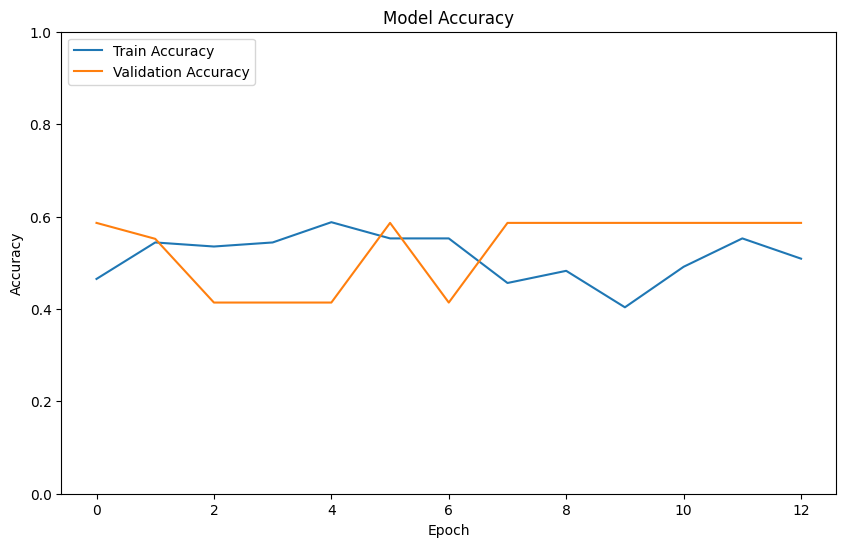

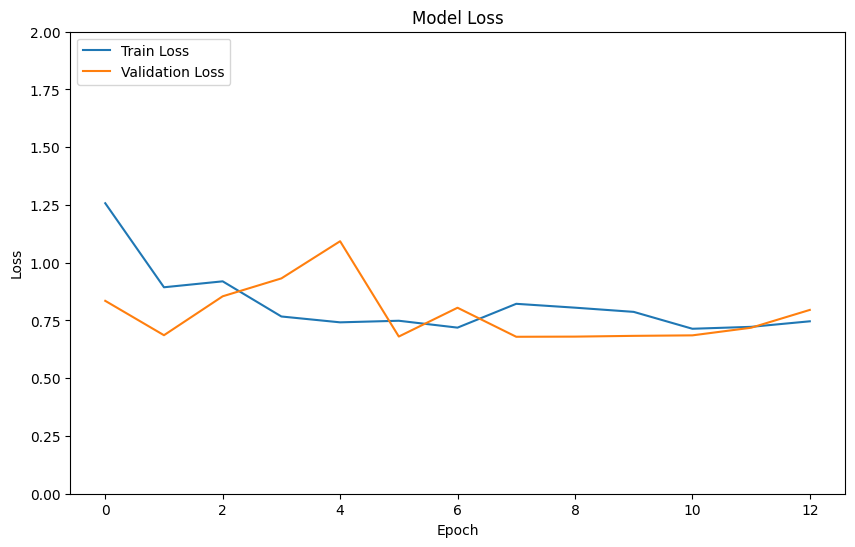

In [240]:
blstm = BLSTM(df, name="codebert_blstm_model", batch_size=10, epochs=100)
blstm.train()

In [241]:
blstm.test()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - AUC: 0.5000 - accuracy: 0.5862 - loss: 0.6794
Test loss: 0.6794040203094482
Test accuracy: 0.5862069129943848
Test AUC: 0.5


In [187]:
class SimpleCodeClassifier:
    def __init__(self, data, model_type="logistic"):
        self.data = data
        self.model_type = model_type

        # Load CodeBERT tokenizer and model
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
        self.embedding_model = AutoModel.from_pretrained("microsoft/codebert-base")

        # Preprocess data and extract embeddings
        self._preprocess_data()

        # Choose classifier
        self.model = self._choose_classifier()

    def _preprocess_data(self):
        # Tokenize code snippets and get embeddings
        embeddings = []
        for code in self.data['code']:
            inputs = self.tokenizer(code, return_tensors="pt", padding=True, truncation=True)
            outputs = self.embedding_model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).detach().numpy()
            embeddings.append(embedding)

        self.X = np.array(embeddings).squeeze()
        self.y = self.data['label'].values

        # Split dataset
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

    def _choose_classifier(self):
        if self.model_type == "logistic":
            return LogisticRegression()
        elif self.model_type == "svm":
            return SVC(probability=True)
        elif self.model_type == "random_forest":
            return RandomForestClassifier()

    def train(self):
        self.model.fit(self.X_train, self.y_train)

    def test(self):
        y_pred = self.model.predict(self.X_test)
        y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]

        accuracy = accuracy_score(self.y_test, y_pred)
        auc = roc_auc_score(self.y_test, y_pred_proba)

        print(f"Test accuracy: {accuracy}")
        print(f"Test AUC: {auc}")

    def predict_code(self, file_path):
        # Read the entire source code from the file
        with open(file_path, 'r') as f:
            code = f.read().strip()
    
        # Tokenize and embed the entire code
        inputs = self.tokenizer(code, return_tensors="pt", padding=True, truncation=True)
        outputs = self.embedding_model(**inputs)
    
        # Take mean of the embeddings along the sequence length to get a single 2D vector
        embedding = outputs.last_hidden_state.mean(dim=1).detach().numpy().squeeze()
    
        # Predict the label (vulnerable or non-vulnerable) for the entire file
        prediction = self.model.predict(np.array([embedding]))[0]  # Predict expects a 2D array
    
        # Interpret the prediction result
        result = "Vulnerable" if prediction == 1 else "Non-Vulnerable"
    
        return result


In [135]:
# Example Usage:
# Assuming 'data' is your pandas DataFrame with 'code' and 'label' columns

simple_classifier = SimpleCodeClassifier(df, model_type="logistic")
simple_classifier.train()

In [136]:
simple_classifier.test()

Test accuracy: 0.8275862068965517
Test AUC: 0.880952380952381


# Predict With BLSTM

In [242]:
# Predicting vulnerability for the whole file
prediction = blstm.predict_code(current_path + '/SourceCode/nonvuln.js')

print(f"The predicted label for the source code is: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The predicted label for the source code is: ('Vulnerable', ["13: const fs = require('fs');", "13: const path = require('path');", "13: const filePath = path.join(__dirname, 'file.txt');", '13: async function readFile() {', '13: try {', '13: await fs.promises.access(filePath, fs.constants.F_OK);', "13: const data = await fs.promises.readFile(filePath, 'utf8');", '13: console.log(data);', '13: } catch (err) {', "13: console.error('Error reading the file:', err.message);", '13: }', '13: }', '13: readFil

In [243]:
# Predicting vulnerability for the whole file
prediction = blstm.predict_code(current_path + '/SourceCode/nonvuln2.js')

print(f"The predicted label for the source code is: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The predicted label for the source code is: ('Vulnerable', ['15: // Function to calculate the factorial of a number', '15: function factorial(n) {', '15: if (n < 0) {', '15: return "Factorial is not defined for negative numbers";', '15: } else if (n === 0 || n === 1) {', '15: return 1; // Base case', '15: } else {', '15: return n * factorial(n - 1); // Recursive case', '15: }', '15: }', '15: // Example usage', '15: const number = 5;', '15: const result = factorial

In [244]:
# Predicting vulnerability for the whole file
prediction = blstm.predict_code(current_path + '/SourceCode/vuln2.js')

print(f"The predicted label for the source code is: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The predicted label for the source code is: ('Vulnerable', ["21: const express = require('express');", "21: const fs = require('fs');", "21: const path = require('path');", '21: const app = express();', '21: const port = 3000;', "21: app.get('/file', (req, res) => {", '21: const fileName = req.query.file;', '21: co

In [245]:
# Predicting vulnerability for the whole file
prediction = blstm.predict_code(current_path + '/SourceCode/vuln2.js')

print(f"The predicted label for the source code is: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The predicted label for the source code is: ('Vulnerable', ["21: const express = require('express');", "21: const fs = require('fs');", "21: const path = require('path');", '21: const app = express();', '21: const port = 3000;', "21: app.get('/file', (req, res) => {", '21: const fileName = req.query.file;', '21: co

In [233]:
prediction, vulnerable_lines = blstm.predict_code(current_path + '/SourceCode/nonvuln.js')

print(f"The predicted label for the source code is: {prediction}")
print(f"Vulnerable lines found:")
for line in vulnerable_lines:
    print(line)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The predicted label for the source code is: Vulnerable
Vulnerable lines found:
13: const fs = require('fs');
13: const path = require('path');
13: const filePath = path.join(__dirname, 'file.txt');
13: async function readFile() {
13: try {
13: await fs.promises.access(filePath, fs.constants.F_OK);
13: const data = await fs.promises.readFile(filePath, 'utf8');
13: console.log(data);
13: } catch (err) {
13: console.error('Error reading the file:', err.message);
13: }
13: }
13: readFile();


# Predict with Simple

In [137]:
file_path = current_path + '/SourceCode/nonvuln.js'  # Replace with your file path
result = simple_classifier.predict_code(file_path)

# Print the prediction result
print("Prediction for the file:", result)

Prediction for the file: Vulnerable


In [138]:
file_path = current_path + '/SourceCode/vuln.js'  # Replace with your file path
result = simple_classifier.predict_code(file_path)

# Print the prediction result
print("Prediction for the file:", result)

Prediction for the file: Non-Vulnerable


In [139]:
file_path = current_path + '/SourceCode/vuln2.js'  # Replace with your file path
result = simple_classifier.predict_code(file_path)

# Print the prediction result
print("Prediction for the file:", result)

Prediction for the file: Vulnerable


In [142]:
file_path = current_path + '/SourceCode/nonvuln2.js'  # Replace with your file path
result = simple_classifier.predict_code(file_path)

# Print the prediction result
print("Prediction for the file:", result)

Prediction for the file: Vulnerable


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f5982bd9-4186-4df6-a44f-a0eeec8cd72d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>